<a href="https://www.kaggle.com/hamedetezadi/restaurant-recommendation-system?scriptVersionId=89786858" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Location-Based Recommendations
# Recommendation systems are widely utilized in different applications for predicting the preference or rating of a user 
# in a product or service. Most likely you have come across or interacted with some type of recommender systems in the past 
# few minutes or hours in your online presence.
# These Recommender systems can be of different types and the most prominent ones include Content-based filtering and Collaborative
# filtering. In this article, we will study location-based recommendations, where we specifically focus on geographic locations to render 
# more relevant recommendations utilizing the location of the users.

# To illustrate the crucial aspects of location-based recommenders we will perform a simple Location-based recommendation using the
#  K-Means algorithm with Yelp Dataset from Kaggle.

In [2]:
# Installing packages on systems like ubuntu.
!apt install gdal-bin python-gdal python3-gdal --yes
# Understanding gdal: https://developers.planet.com/planetschool/getting-started-with-gdal/
!apt install python3-rtree --yes
!pip install git+git://github.com/geopandas/geopandas.git --yes
# Understanding GeoPandas: https://github.com/geopandas/geopandas
!pip install descartes 
!pip install folium 
!pip install plotly_express





Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate



The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore
Suggested packages:
  apache2 | lighttpd | httpd
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore python3-rtree
0 upgraded, 4 newly installed, 0 to remove and 33 not upgraded.
Need to get 489 kB of archives.
After this operation, 1516 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 javascript-common all 11 [6066 B]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libjs-jquery all 3.3.1~dfsg-3 [329 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libjs-underscore all 1.9.1~

In [3]:
import pandas as pd 
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import folium

import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
!wget https://www.dropbox.com/s/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
!unzip yelp_academic_dataset_business.zip --yes

--2022-03-10 21:00:12--  https://www.dropbox.com/s/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3x1w789mmuae3ao/yelp_academic_dataset_business.zip [following]
--2022-03-10 21:00:13--  https://www.dropbox.com/s/raw/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad5b3a33bd4d447392347d10c3.dl.dropboxusercontent.com/cd/0/inline/BhOMUuf0JoQCe_V4Sx2rQ_A_oj9uq7J9SekjRW7VnRZlinGSXjXU2fBm4khChTR3WJrODystWceigTwNg5m4Q0f6V0LcnEwUYXJ6FhdEXSrTqso3ONd61feyhe7PBvpIMwFaIOdWk9gKq77eiVyX_i9Q-UD1KnZUdrLTclotIViXWA/file# [following]
--2022-03-10 21:00:13--  https://ucad5b3a33bd4d447392347d10c3.dl.dropboxusercontent.com/cd/0/inline/Bh

In [5]:
df = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_business.json', lines=True)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [6]:
df.shape

(160585, 14)

## Exploratory Data Analaysis (EDA)

In [7]:
df['Restaurants'] = df['categories'].str.contains('Restaurants')
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",True
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",True


In [8]:
df_restaurants = df.loc[df.Restaurants == True]
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",True
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",True
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...",True
7,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}",True
12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",True


In [9]:
df_restaurants.shape

(50763, 15)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



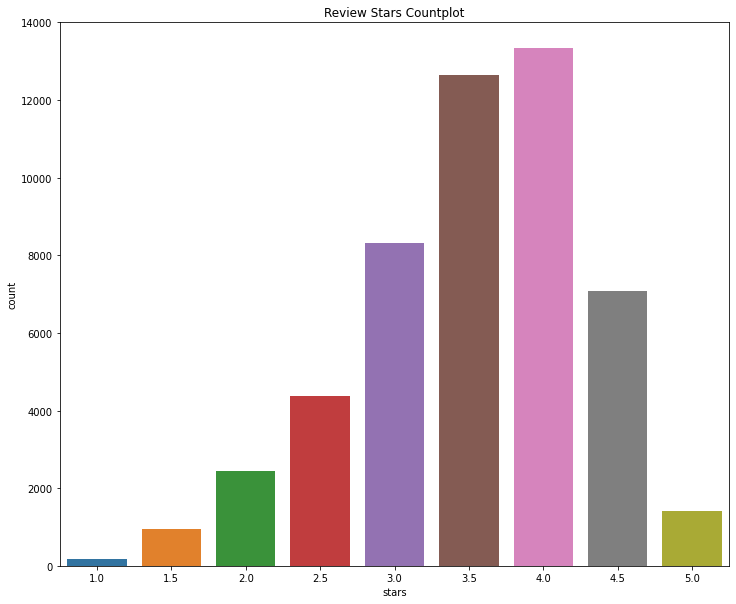

In [10]:

fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(df_restaurants['stars'], ax=ax)
plt.title('Review Stars Countplot')
# plt.savefig('stars.png')
plt.show()

In [11]:
top_restaurants = df_restaurants.sort_values(by=['review_count', 'stars'], ascending=False)[:20]
top_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
64048,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,22 SW 3rd Ave,Portland,OR,97204,45.522612,-122.673084,3.5,9185,1,"{'RestaurantsPriceRange2': '1', 'BikeParking':...","Local Flavor, Food, Donuts, Wedding Chapels, E...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-21:0', '...",True
113608,PrsvO1rzkgg6qFizlAoEtg,Mike's Pastry,300 Hanover St,Boston,MA,02113,42.364181,-71.054218,4.0,7298,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Candy Stores, Gelato, Food, Coffee & Tea, Rest...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",True
42375,OQ2oHkcWA8KNC1Lsvj1SBA,Screen Door,2337 E Burnside St,Portland,OR,97214,45.523086,-122.641680,4.5,7219,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Caterers, Restaurants, Breakfast & Brunch, Sou...","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",True
25571,zioLxtBc9THNS2TOn9xW1w,Pok Pok,3226 SE Division St,Portland,OR,97202,45.504723,-122.632105,4.0,6221,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Asian Fusion, Pan Asian, Thai, Fi...","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",True
145385,y2w6rFaO0XEiG5mFfOsiFA,Neptune Oyster,63 Salem St,Boston,MA,02113,42.363237,-71.055975,4.5,5115,1,"{'NoiseLevel': 'u'average'', 'RestaurantsAttir...","Arabian, Thai, American (Traditional), Live/Ra...","{'Monday': '11:30-21:30', 'Tuesday': '11:30-21...",True


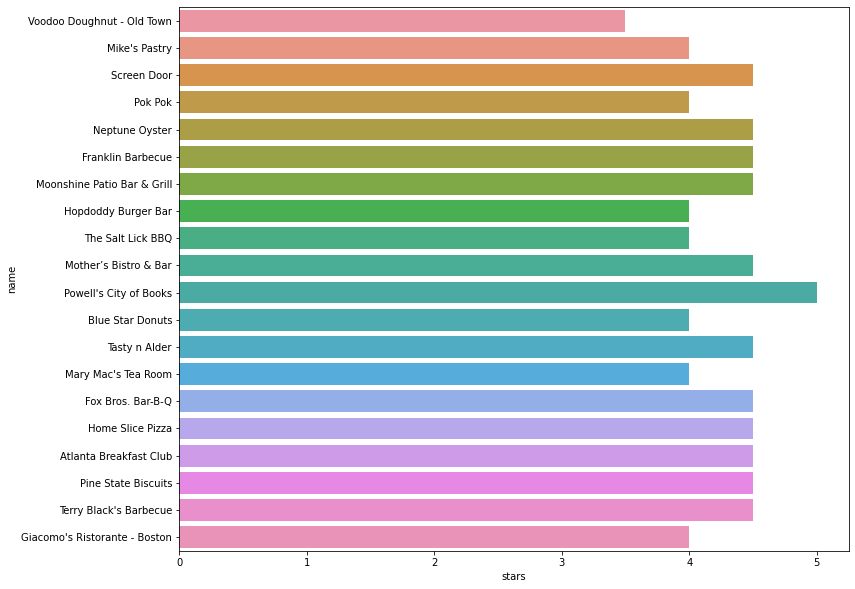

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'stars', y = 'name', data=top_restaurants, ax= ax);
plt.savefig('top20_restaurants.png')
plt.show()

In [13]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2lkZHAyNzQiLCJhIjoiY2txZHM2bjdyMDd6bjJvbWxkcG5odW5zNCJ9.SZll1uNjsTQ-IdGd1n7zCw")
#configure_plotly_browser_state()
px.scatter_mapbox(df_restaurants, lat="latitude", lon="longitude", color="stars", size='review_count' ,
                   size_max=30, zoom=3, width=1200, height=800)

In [14]:
Vancouver = df_restaurants[df_restaurants.state == 'BC']
px.scatter_mapbox(Vancouver, lat="latitude", lon="longitude", color="stars", size='review_count' ,
                   size_max=15, zoom=10, width=1200, height=800)

## K-Means Clustering

### Determing the number of clusters (K)

In [15]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = Vancouver[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)



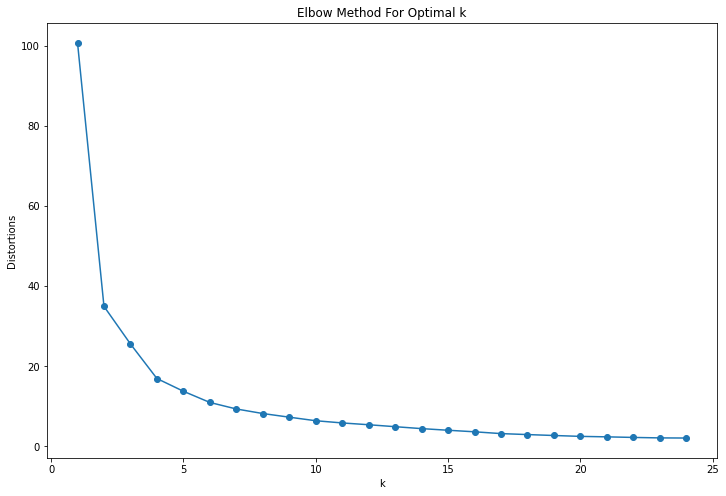

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
# plt.savefig('elbow.png')
plt.show()

Silhoute method


In [17]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [18]:
sil

[0.6422768831579978,
 0.48998694463243486,
 0.5141366862404088,
 0.49751089194911235,
 0.48255497205009124,
 0.4436934189160119,
 0.47061545813727046,
 0.47459312748581717,
 0.47607958113975213,
 0.4687329041490132,
 0.48775400819528353,
 0.48160019523396014,
 0.4922408622079623,
 0.47310415091178637,
 0.5010322602656129,
 0.4663110617395927,
 0.4797309832086201,
 0.5055485742285163,
 0.5036123210415864,
 0.48951946215771774,
 0.47337589041080114,
 0.47632551281545227,
 0.49393081870314975,
 0.4729996085049695,
 0.4897453542696861,
 0.4947353364607916,
 0.4973928529746919,
 0.47846322301908406,
 0.5030604303143605,
 0.5182777825945282,
 0.5206044238547635,
 0.5078713734618219,
 0.5099696023037996,
 0.49395100157251154,
 0.5158971427077352,
 0.5085315142916746,
 0.5131117385650572,
 0.5089314539659391,
 0.5279541871017406,
 0.5271294657230446,
 0.5191740450225908,
 0.5217623222043067,
 0.5253884172332333,
 0.5245577199867542,
 0.5230753359764909,
 0.5163563368657069,
 0.5149578434929067

### K-Means Clustering

In [19]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 5", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 5  silhouette_score  0.49751089194911235


In [20]:
Vancouver['cluster'] = kmeans.predict(Vancouver[['longitude','latitude']])
Vancouver.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,cluster
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...",True,0
33,QciD6FbNklaJvUbLExD4Nw,ARGO,"3790 Canada Way, Unit 108",Burnaby,BC,V5G 1G4,49.254436,-123.020050,4.0,76,1,"{'WheelchairAccessible': 'False', 'Restaurants...","Food Delivery Services, Food, Restaurants, Med...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-21:0',...",True,3
47,Xi2GGNzOiUS8r6WCFvu-fw,Kerala Kitchen,103- 9386 120 Street,Surrey,BC,V3V 4B9,49.173723,-122.889641,4.0,9,1,"{'BusinessParking': '{'garage': False, 'street...","Indian, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",True,1
112,NoPXKdIwRzflOW-5exFAqA,1st Avenue Seafood by Pocha,901 Lougheed Hwy,Coquitlam,BC,V3K 3T3,49.237547,-122.872628,4.0,12,0,"{'Ambience': '{'touristy': False, 'hipster': F...","Restaurants, Korean, Seafood","{'Tuesday': '11:30-23:0', 'Wednesday': '11:30-...",True,1
131,jfDfHzAq6iKkRnzzZ4n1nQ,Let's Roll Custom Sushi Bar,"1184 Denman Street, Suite 104",Vancouver,BC,V6G 2M9,49.286360,-123.140261,4.5,31,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Canadian (New), Sushi Bars, Ameri...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",True,0


In [21]:
px.scatter_mapbox(Vancouver, lat="latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1200, height=800)

## Location-Based Recommendation

In [22]:
top_restaurants_Vancouver = Vancouver.sort_values(by=['review_count', 'stars'], ascending=False)
top_restaurants_Vancouver.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,cluster
5209,VPqWLp9kMiZEbctCebIZUA,Medina Cafe,780 Richards Street,Vancouver,BC,V6B 3A4,49.280443,-123.117036,4.0,2302,1,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Bars, Moroccan, Wine Bars, Breakfast & Brunch,...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '...",True,0
68607,4EV_ZcQmjAmP3pmO-_nb2A,Miku,"200 Granville Street, Suite 70",Vancouver,BC,V6C 1S4,49.287008,-123.113051,4.5,1805,1,"{'RestaurantsAttire': ''casual'', 'BikeParking...","Japanese, Sushi Bars, Restaurants","{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",True,0
97282,_4R46MNkwx9MeOyt0YfNxA,Chambar,568 Beatty Street,Vancouver,BC,V6B 2L3,49.280146,-123.109925,4.0,1356,1,"{'GoodForKids': 'False', 'RestaurantsReservati...","Cafes, Middle Eastern, Nightlife, Breakfast & ...","{'Monday': '0:0-0:0', 'Thursday': '9:0-22:0', ...",True,0
50355,yeNenSjz_HCqngGFU5d8NQ,Phnom Penh,244 E Georgia Street,Vancouver,BC,V6A 1Z7,49.278431,-123.098205,4.0,1306,1,"{'RestaurantsPriceRange2': '2', 'Caters': 'Fal...","Vietnamese, Cambodian, Restaurants","{'Monday': '11:0-19:0', 'Tuesday': '11:0-19:0'...",True,0
50851,LjdbthVdtLYKSi7iVAFl0g,Jam Cafe on Beatty,556 Beatty Street,Vancouver,BC,V6B 2L3,49.280155,-123.109542,4.5,1097,1,"{'RestaurantsTakeOut': 'True', 'Ambience': '{'...","Breakfast & Brunch, Restaurants","{'Monday': '8:0-15:0', 'Tuesday': '8:0-15:0', ...",True,0


In [23]:
def recommend_restaurants(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
   
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude'	]]
   

In [24]:
recommend_restaurants(top_restaurants_Vancouver,-115.1891691,  36.1017316)

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude
54886,Lazzez's Grill Indian Cuisine,49.277355,-122.804792
7107,The Boathouse Restaurant,49.280961,-122.850478
125660,Originals Cafe Mexicano,49.277625,-122.861945
42906,Jimoco Cafe & Pasta,49.248794,-122.863944
17647,Cora,49.274923,-122.791039


In [25]:
recommend_restaurants(top_restaurants_Vancouver,-115.2798544, 36.0842838) 

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude
54886,Lazzez's Grill Indian Cuisine,49.277355,-122.804792
7107,The Boathouse Restaurant,49.280961,-122.850478
125660,Originals Cafe Mexicano,49.277625,-122.861945
42906,Jimoco Cafe & Pasta,49.248794,-122.863944
17647,Cora,49.274923,-122.791039


In [26]:
recommend_restaurants(top_restaurants_Vancouver, 	-115.082821, 36.155011 )

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude
54886,Lazzez's Grill Indian Cuisine,49.277355,-122.804792
7107,The Boathouse Restaurant,49.280961,-122.850478
125660,Originals Cafe Mexicano,49.277625,-122.861945
42906,Jimoco Cafe & Pasta,49.248794,-122.863944
17647,Cora,49.274923,-122.791039


In [27]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [36.1017316, 36.0842838, 36.155011],
    'longitude' : [-115.1891691, -115.2798544, -115.082821],
}

test_df = pd.DataFrame(test_coordinates)
test_df

,user,latitude,longitude
0,1,36.101732,-115.189169
1,2,36.084284,-115.279854
2,3,36.155011,-115.082821


In [28]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,36.101732,-115.189169


In [29]:
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_Vancouver, user1.longitude, user1.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [30]:
user2 = test_df[test_df['user'] == 2].reset_index()
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_Vancouver, user2.longitude, user2.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user2["latitude"], lon= user2["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [31]:
user3 = test_df[test_df['user'] == 2].reset_index()
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_Vancouver, user3.longitude, user3.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user3["latitude"], lon= user3["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

4


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

